# **OptimizeYoloV5WithTensorRT:**

In [1]:
!pip install --upgrade --index-url https://pypi.ngc.nvidia.com nvidia-tensorrt

import tensorrt as trt

trt.__version__

Looking in indexes: https://pypi.ngc.nvidia.com, https://us-python.pkg.dev/colab-wheels/public/simple/


'8.4.1.5'

In [2]:
!pip install onnx onnxsim pycuda onnxruntime-gpu==1.9
import numpy as np
import time

import onnx
from onnxsim import simplify

import tensorrt as trt
import pycuda.autoinit
import pycuda.driver as cuda

import os.path

import cv2
import matplotlib.pyplot as plt

#https://github.com/ultralytics/yolov5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!ls yolov5

CONTRIBUTING.md  export.py   models	       setup.cfg       utils
data		 hubconf.py  README.md	       train.py        val.py
detect.py	 LICENSE     requirements.txt  tutorial.ipynb


In [4]:
!python3 yolov5/export.py --weights yolov5s.pt --img 640 --batch 1
!python3 yolov5/export.py --weights yolov5m.pt --img 640 --batch 1
!python3 yolov5/export.py --weights yolov5l.pt --img 640 --batch 1

export: data=yolov5/data/coco128.yaml, weights=['yolov5s.pt'], imgsz=[640], batch_size=1, device=cpu, half=False, inplace=False, train=False, keras=False, optimize=False, int8=False, dynamic=False, simplify=False, opset=12, verbose=False, workspace=4, nms=False, agnostic_nms=False, topk_per_class=100, topk_all=100, iou_thres=0.45, conf_thres=0.25, include=['torchscript', 'onnx']
YOLOv5 🚀 v6.1-382-ge242ede Python-3.7.13 torch-1.12.0+cu113 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients

PyTorch: starting from yolov5s.pt with output shape (1, 25200, 85) (14.1 MB)

TorchScript: starting export with torch 1.12.0+cu113...
TorchScript: export success, saved as yolov5s.torchscript (28.1 MB)

ONNX: starting export with onnx 1.12.0...
ONNX: export success, saved as yolov5s.onnx (28.0 MB)

Export complete (8.33s)
Results saved to /content
Detect:          python detect.py --weights yolov5s.onnx 
Validate:        python val.py --weights yolov5s.onnx 
PyTorch Hu

In [5]:
!mkdir YoloV5

mkdir: cannot create directory ‘YoloV5’: File exists


In [6]:
!cp yolov5s.onnx Yolov5

In [170]:
#!ls -l
#!mkdir YoloV5
#!cp yolov5s.onnx YoloV5/.
!ls -l YoloV5
#!ls -l
#!rmdir YoloV5

total 87872
-rw-r--r-- 1 root root 29336806 Aug 10 08:12 yolov5s.onnx
-rw-r--r-- 1 root root 31292622 Aug 10 08:17 yolov5sOptimized.trt
-rw-r--r-- 1 root root 29345687 Aug 10 09:43 yolov5s-simplified.onnx


In [171]:
#!git clone https://github.com/ultralytics/yolov5.git

# load your predefined ONNX model
model = onnx.load('./YoloV5/yolov5s.onnx')

'''
!pip install cvu-python
from cvu.detector.yolov5 import Yolov5 as Yolov5Onnx

model = Yolov5Onnx(classes="coco",
                    backend="onnx",
                    weight="yolov5s",
                    device="auto")
'''

'\n!pip install cvu-python\nfrom cvu.detector.yolov5 import Yolov5 as Yolov5Onnx\n\nmodel = Yolov5Onnx(classes="coco",\n                    backend="onnx",\n                    weight="yolov5s",\n                    device="auto")\n'

In [172]:
# convert model
model_simp, check = simplify(model)

In [173]:
# save simplified model
with open("./YoloV5/yolov5s-simplified.onnx", "wb") as f:
    f.write(model_simp.SerializeToString())

print("Saved onnx model to model-simplified.onnx")

Saved onnx model to model-simplified.onnx


In [174]:
logger = trt.Logger(trt.Logger.VERBOSE)
logger.min_severity = trt.Logger.Severity.VERBOSE
EXPLICIT_BATCH = []

In [175]:
def load_engine(engine_path):
    with open(engine_path, "rb") as f, trt.Runtime(logger) as runtime:
        return runtime.deserialize_cuda_engine(f.read())

print('trt version', trt.__version__)

trt version 8.4.1.5


In [176]:
if not os.path.exists('./YoloV5/yolov5sOptimized.trt'):
    if trt.__version__[0] >= '7':
        EXPLICIT_BATCH.append(1 << (int)(trt.NetworkDefinitionCreationFlag.EXPLICIT_BATCH))

    with trt.Builder(logger) as builder, builder.create_builder_config() as config, builder.create_network(*EXPLICIT_BATCH) as network, trt.OnnxParser(network,
                                                                                                            logger) as parser:
        #config.max_workspace_size = 1 << 28
        #builder.max_workspace_size = 1 << 28
        builder.max_batch_size = 1
        #builder.fp16_mode = False

        with open('./YoloV5/yolov5s-simplified.onnx', 'rb') as f:
            if not parser.parse(f.read()):
                for error in range(parser.num_errors):
                    print(parser.get_error(error))
            else:
                print("Parsed ONNX successfully")

        # reshape input from 32 to 1
        shape = list(network.get_input(0).shape)
        print("building tensorrt engine")
        #engine = builder.build_cuda_engine(network)
        engine = builder.build_engine(network, config)
        print("Saving serialized model")
        with open('./YoloV5/yolov5sOptimized.trt', 'wb') as f:
            f.write(engine.serialize())

        print("Done")
else:
    engine = load_engine('./YoloV5/yolov5sOptimized.trt')

In [177]:
class HostDeviceMem(object):
    def __init__(self, host_mem, device_mem):
        """Within this context, host_mom means the cpu memory and device means the GPU memory
        """
        self.host = host_mem
        self.device = device_mem

    def __str__(self):
        return "Host:\n" + str(self.host) + "\nDevice:\n" + str(self.device)

    def __repr__(self):
        return self.__str__()

In [178]:
def allocate_buffers(engine):
    inputs = []
    outputs = []
    bindings = []
    stream = cuda.Stream()
    for binding in engine:
        size = trt.volume(engine.get_binding_shape(binding)) * engine.max_batch_size
        dtype = trt.nptype(engine.get_binding_dtype(binding))
        # Allocate host and device buffers
        host_mem = cuda.pagelocked_empty(size, dtype)
        device_mem = cuda.mem_alloc(host_mem.nbytes)
        # Append the device buffer to device bindings.
        bindings.append(int(device_mem))
        # Append to the appropriate list.
        if engine.binding_is_input(binding):
            inputs.append(HostDeviceMem(host_mem, device_mem))
        else:
            outputs.append(HostDeviceMem(host_mem, device_mem))
    return inputs, outputs, bindings, stream


In [179]:
ctx = engine.create_execution_context()

# Allocate buffers for input and output
inputs, outputs, bindings, stream = allocate_buffers(engine)  # input, output: host # bindings

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Use network created with NetworkDefinitionCreationFlag::EXPLICIT_BATCH flag instead.
  import sys


In [180]:
def do_inference(context, bindings, inputs, outputs, stream, batch_size=1):
    # Transfer data from CPU to the GPU.
    [cuda.memcpy_htod_async(inp.device, inp.host, stream) for inp in inputs]
    # Run inference.
    context.execute_async(batch_size=batch_size, bindings=bindings, stream_handle=stream.handle)
    # Transfer predictions back from the GPU.
    [cuda.memcpy_dtoh_async(out.host, out.device, stream) for out in outputs]
    # Synchronize the stream
    stream.synchronize()
    # Return only the host outputs.
    return [out.host for out in outputs]

In [181]:
!ls yolov5/data/images

bus.jpg  zidane.jpg


In [182]:
import cv2
image = cv2.imread('./yolov5/data/images/bus.jpg')
resized = cv2.resize(image, (640,640))
img_in = np.transpose(resized, (2, 0, 1)).astype(np.float32)
img_in = np.expand_dims(img_in, axis=0)
img_in /= 255

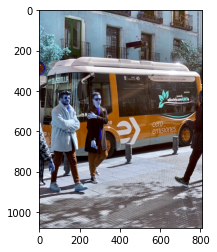

In [183]:
plt.figure()
plt.imshow(image)

In [184]:
def postprocess_the_outputs(h_outputs, shape_of_output):
    h_outputs = h_outputs.reshape(*shape_of_output)
    return h_outputs

In [ ]:
max_batch_size = 1 # The batch size of input mush be smaller the max_batch_size once the engine is built

np.copyto(inputs[0].host, img_in.ravel())

outputs = do_inference(ctx, bindings, inputs, outputs, stream)
outputs = np.squeeze(outputs).tolist() # Added by Nir

# Print the shape of each output
for output in outputs:
    out = np.asanyarray(output).reshape(1, int(len(output) / 85), 85)
    print(out.shape)

#outputs = outputs[0].tolist() # Added by Nir
out_concat = np.asanyarray(outputs[3]).reshape(1, int(len(outputs[3]) / 85), 85)